<a href="https://colab.research.google.com/github/joshsalako/fishnet/blob/main/fishnet_retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.datasets import VOCDetection
import torchvision.transforms as T
from torch.optim import SGD, Adam
from torchvision.models.detection.retinanet import RetinaNetHead
from torchvision.datasets.vision import StandardTransform
import torchvision
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.datasets.coco import CocoDetection
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv
import albumentations as A
from sklearn.metrics import precision_recall_curve, average_precision_score
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
train_dataset = VOCDetection(root='/content/drive/MyDrive/Catfish',
                             year='2007',
                             image_set='train',
                             #transform=transform,
                             download=False)
val_dataset = VOCDetection(root='/content/drive/MyDrive/Catfish',
                             year='2007',
                             image_set='val',
                             #transform=transform,
                             download=False)

In [13]:
label_to_int = {'fish': 1}  # Adjust this mapping to include all your labels

def custom_collate(batch):
    processed_images = []
    processed_targets = []

    transform = A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    for img, target in batch:
        img = np.array(img)  # Convert PIL Image to numpy array
        boxes = boxes = [[float(coord) for coord in obj['bndbox'].values()] for obj in target['annotation']['object']]
        labels = [label_to_int[obj['name']] for obj in target['annotation']['object']]
        transformed = transform(image=img, bboxes=boxes, class_labels=labels)
        processed_images.append(transformed['image'])
        processed_targets.append({
            'boxes': torch.tensor(transformed['bboxes'], dtype=torch.float32),
            'labels': torch.tensor(transformed['class_labels'], dtype=torch.long)
        })

    return torch.stack(processed_images), processed_targets

def custom_collate_val(batch):
    processed_images = []
    processed_targets = []

    transform = A.Compose([
        A.Resize(224, 224),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Rotate(limit=30, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    for img, target in batch:
        img = np.array(img)  # Convert PIL Image to numpy array
        boxes = boxes = [[float(coord) for coord in obj['bndbox'].values()] for obj in target['annotation']['object']]
        labels = [label_to_int[obj['name']] for obj in target['annotation']['object']]
        transformed = transform(image=img, bboxes=boxes, class_labels=labels)
        processed_images.append(transformed['image'])
        processed_targets.append({
            'boxes': torch.tensor(transformed['bboxes'], dtype=torch.float32),
            'labels': torch.tensor(transformed['class_labels'], dtype=torch.long)
        })

    return torch.stack(processed_images), processed_targets

In [15]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=custom_collate_val)

In [16]:
# Step 2: Load the pre-trained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)

# Step 3: Modify the model for your specific task
num_classes = 2  # Get number of classes from VOC dataset

# Create a new RetinaNet head with the correct number of classes
new_head = RetinaNetHead(
    in_channels=model.backbone.out_channels,
    num_anchors=model.head.classification_head.num_anchors,
    num_classes=num_classes  # New number of classes
)

# Replace the existing head with the new head
model.head = new_head

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def print_model_summary(model):
    print("Model Summary:\n")
    for name, param in model.named_parameters():
        print(f"Layer: {name} | Size: {param.size()} | Trainable: {param.requires_grad}")

print_model_summary(model)

Model Summary:

Layer: backbone.body.conv1.weight | Size: torch.Size([64, 3, 7, 7]) | Trainable: False
Layer: backbone.body.layer1.0.conv1.weight | Size: torch.Size([64, 64, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.0.conv2.weight | Size: torch.Size([64, 64, 3, 3]) | Trainable: False
Layer: backbone.body.layer1.0.conv3.weight | Size: torch.Size([256, 64, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.0.downsample.0.weight | Size: torch.Size([256, 64, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.1.conv1.weight | Size: torch.Size([64, 256, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.1.conv2.weight | Size: torch.Size([64, 64, 3, 3]) | Trainable: False
Layer: backbone.body.layer1.1.conv3.weight | Size: torch.Size([256, 64, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.2.conv1.weight | Size: torch.Size([64, 256, 1, 1]) | Trainable: False
Layer: backbone.body.layer1.2.conv2.weight | Size: torch.Size([64, 64, 3, 3]) | Trainable: False
Layer: backb

In [18]:
for param in model.backbone.parameters():
    param.requires_grad = False

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [20]:
# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Step 4: Train the model
optimizer = Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 60
min_val_loss = float('inf')

# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Create a CSV file to log the losses
with open('/content/drive/MyDrive/Catfish/retina_loss_log.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            # Move data to the device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            #print(losses)
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip gradients
            optimizer.step()

            train_loss += losses.item()

        # Calculate average training loss
        train_loss /= len(train_loader)

        #model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                # Move data to the device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                #print(loss_dict)
                val_loss += sum(loss.item() for loss in loss_dict.values())

        # Calculate average validation loss
        val_loss /= len(val_loader)
        # Step the scheduler
        scheduler.step(val_loss)

        if val_loss < min_val_loss:
        # Update the minimum validation loss
            min_val_loss = val_loss
            # Save the model
            torch.save(model.state_dict(), '/content/drive/MyDrive/Catfish/retinanet_model.pth')
            print(f'Saving model at epoch {epoch} with Validation Loss: {val_loss:.4f}')

        # Log losses to the CSV file
        writer.writerow([epoch, train_loss, val_loss])

        # Print losses
        print(f'Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Saving model at epoch 0 with Validation Loss: 1.6081
Epoch 0, Training Loss: 4894.4873, Validation Loss: 1.6081
Epoch 1, Training Loss: 3.0493, Validation Loss: 34.1506
Epoch 2, Training Loss: 3.8750, Validation Loss: 1.7290
Epoch 3, Training Loss: 3.5399, Validation Loss: 1.6596
Epoch 4, Training Loss: 1.7127, Validation Loss: 1.8305
Saving model at epoch 5 with Validation Loss: 1.4522
Epoch 5, Training Loss: 1.7565, Validation Loss: 1.4522
Epoch 6, Training Loss: 1.4486, Validation Loss: 1.6702
Saving model at epoch 7 with Validation Loss: 1.1789
Epoch 7, Training Loss: 1.5855, Validation Loss: 1.1789
Epoch 8, Training Loss: 5.9440, Validation Loss: 1.7303
Epoch 9, Training Loss: 4.8131, Validation Loss: 1.3185
Epoch 10, Training Loss: 1.7355, Validation Loss: 1.3078
Epoch 11, Training Loss: 1.2591, Validation Loss: 1.8390
Epoch 12, Training Loss: 1.3315, Validation Loss: 1.3748
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
Epoch 13, Training Loss: 1.3985, Validation 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Precision: 0.12782352649884185
Recall: 0.7961845730027549
AP50: 0.2223488837338149
AP95: -0.0
mAP: 0.11117444186690745


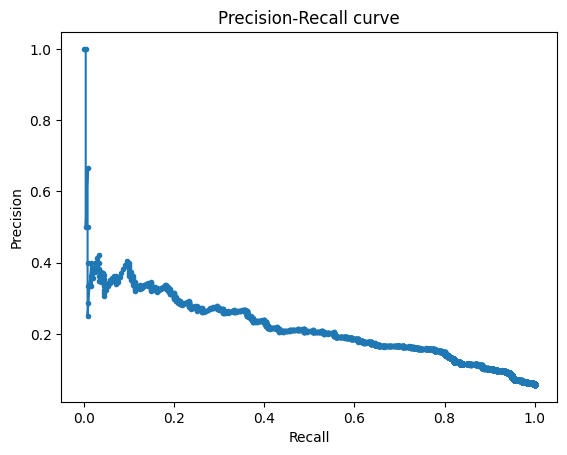

In [22]:
def compute_iou(box1, boxes2):
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    inter_x1 = torch.max(box1[0], boxes2[:, 0])
    inter_y1 = torch.max(box1[1], boxes2[:, 1])
    inter_x2 = torch.min(box1[2], boxes2[:, 2])
    inter_y2 = torch.min(box1[3], boxes2[:, 3])

    inter_area = torch.clamp((inter_x2 - inter_x1), min=0) * torch.clamp((inter_y2 - inter_y1), min=0)
    union_area = box1_area + boxes2_area - inter_area

    iou = inter_area / (union_area + 1e-6)  # Adding a small epsilon to avoid division by zero

    return iou.cpu().numpy()

def evaluate(model, val_loader, device):
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode

    all_labels50 = []
    all_scores50 = []

    all_labels75 = []
    all_scores75 = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)

            outputs = model(images)

            for output, target in zip(outputs, targets):
                labels = np.zeros(len(output['boxes']))
                scores = output['scores'].cpu().numpy()
                labels75 = labels.copy()

                for box in target['boxes']:
                    ious = compute_iou(box, output['boxes'])
                    labels[ious > 0.5] = 1

                all_labels50.append(labels)
                all_scores50.append(scores)

                for box in target['boxes']:
                    ious = compute_iou(box, output['boxes'])
                    labels75[ious > 0.95] = 1

                all_labels75.append(labels75)
                all_scores75.append(scores)

    all_labels50 = np.concatenate(all_labels50)
    all_scores50 = np.concatenate(all_scores50)

    all_labels75 = np.concatenate(all_labels75)
    all_scores75 = np.concatenate(all_scores75)

    precision50, recall50, _ = precision_recall_curve(all_labels50, all_scores50)
    precision75, recall75, _ = precision_recall_curve(all_labels75, all_scores75)
    ap_50 = average_precision_score(all_labels50, all_scores50)
    ap_75 = average_precision_score(all_labels75, all_scores75)

    mAP = (ap_50 + ap_75) / 2

    avg_precision = np.mean(precision50)
    avg_recall = np.mean(recall50)

    print(f'Precision: {avg_precision}')
    print(f'Recall: {avg_recall}')
    print(f'AP50: {ap_50}')
    print(f'AP95: {ap_75}')
    print(f'mAP: {mAP}')

    plt.figure()
    plt.plot(recall50, precision50, marker='.')
    plt.title('Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

# Assume model, val_loader are already loaded/defined

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Call the evaluate function
evaluate(model, val_loader, device)